In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import sys
from pathlib import Path
import anndata as ad
import scanpy as sc
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns
from matplotlib import pyplot as plt
import time

sys.path.insert(0, "/home/ylu/project/Benchmark_alignment_methods/scripts/methods")
from my_STAlign import stalign_align

%load_ext autoreload
%autoreload 2

In [2]:
order = [
    155, 153,151,149,147,144,142,140, 138, 143,141,139, 137,135,133,130,131,
129,127,125,123,121,119,117,115,113,111,109,107,105,103, 101, 99, 97, 95, 93,
91,89,87,85,81,83,79,77,75,73,71,67,65,63,61,59,57,55,53,51,49,47,45,43,41,39,
37,33,31,29,27,25,28,30,32,34,36,38,40,42,44,48,50,52,54,56,58,60,62,
    64,66,68,72,74,76,78,80,82,84,88,90,92,94,96,98,100,102,104,106,108,
    110,112,114,116,118,120,122,124,136,134,132,128,126
]
data_folder = "/dm7100f/yifan/StereoSeq_macaque_processed"
files = [f'macaque_T{o}.h5ad' for o in order]

In [3]:
# data_folder = "./results/split_data/"
results_folder = "./results/STAlign_whole/"
figures_folder = "./results/figures/STAlign_whole"
Path(results_folder).mkdir(parents=True, exist_ok=True)

In [5]:
spatial_key = 'r_spatial'
key_added = 'align_spatial'
i = 50
slice1 = ad.read_h5ad(os.path.join(data_folder, files[i]))
slice2 = ad.read_h5ad(os.path.join(data_folder, files[i+1]))
slice1.obsm[spatial_key] = slice1.obsm[spatial_key].astype(np.float64)
slice2.obsm[spatial_key] = slice2.obsm[spatial_key].astype(np.float64)

0 of 219853
10000 of 219853
20000 of 219853
30000 of 219853
40000 of 219853
50000 of 219853
60000 of 219853
70000 of 219853
80000 of 219853
90000 of 219853
100000 of 219853
110000 of 219853
120000 of 219853
130000 of 219853
140000 of 219853
150000 of 219853
160000 of 219853
170000 of 219853
180000 of 219853
190000 of 219853
200000 of 219853
210000 of 219853
219852 of 219853


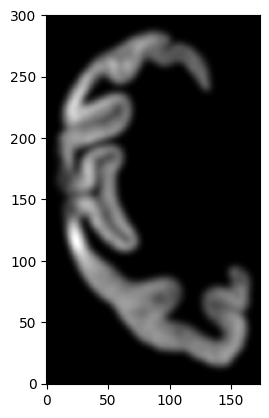

In [8]:
sys.path.insert(0, "/home/ylu/project/STalign")
from STalign import STalign
factor = 0.1
xI = slice1.obsm[spatial_key][:,0] * factor
yI = slice1.obsm[spatial_key][:,1] * factor
xJ = slice2.obsm[spatial_key][:,0] * factor
yJ = slice2.obsm[spatial_key][:,1] * factor
XI,YI,I,fig = STalign.rasterize(xI,yI,dx=30,blur=1.5)

# plot
ax = fig.axes[0]
ax.invert_yaxis()

In [14]:
from tqdm import tqdm
## Perform the STAlign alignment
import torch
spatial_key = 'r_spatial'
key_added = 'align_spatial'
# for i in tqdm(range(len(slices)-1)):
for i in tqdm(range(len(files)-1)):
    slice1 = ad.read_h5ad(os.path.join(data_folder, files[i]))
    slice2 = ad.read_h5ad(os.path.join(data_folder, files[i+1]))
    slice1.obsm[spatial_key] = slice1.obsm[spatial_key].astype(np.float64)
    slice2.obsm[spatial_key] = slice2.obsm[spatial_key].astype(np.float64)
    slice1 = slice1[~np.isnan(slice1.obsm[spatial_key].sum(1))]
    slice2 = slice2[~np.isnan(slice2.obsm[spatial_key].sum(1))]
    if i >0:
        previous_results = np.load(os.path.join(results_folder, f"slice_{i-1}_{i}.npy"), allow_pickle=True).item()
        slice2_spatial = previous_results['slice2_spatial']
        slice1.obsm[spatial_key] = slice2_spatial.copy()
    time_start = time.time()

    align_slices = stalign_align(
        models = [slice1, slice2],
        spatial_key = spatial_key,
        key_added = key_added,
        device = "cuda:0",
        scale=0.1,
        zero_mean=False,
    )
    
    time_end = time.time()
    alignment_results = {'slice1_spatial':align_slices[0].obsm[key_added], 'slice2_spatial': align_slices[1].obsm[key_added], 'time': time_end - time_start}
    np.save(os.path.join(results_folder, f"slice_{i}_{i+1}.npy"), alignment_results, allow_pickle=True)

  0%|                                                                                                                                                                                                                                 | 0/47 [00:00<?, ?it/s]/home/ylu/anaconda3/envs/STAlign/lib/python3.9/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
  2%|████▌                                                                                                                                                                                                                 | 1/47 [03:30<2:41:08, 210.18s/it]/home/ylu/anaconda3/envs/STAlign/lib/python3.9/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone()